In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.text import *

In [3]:
PATH = Path('data/IAM_handwriting')
TMP_PATH = PATH/'tmp'

# !ls {PATH}

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prelim

## Converting forms to paragraphs

### crop forms via xml info

In [5]:
import xml.etree.ElementTree as ET
xml = PATH/'xml'

def parse_xml(fname):
    tree = ET.parse(xml/fname)
    root = tree.getroot()
    
    words = []
    for part in root:
        for line in part:
            for word in line.findall('word'):
                for cmp in word:
                    x,y = int(cmp.attrib['x']), int(cmp.attrib['y'])
                    rx,ry = x+int(cmp.attrib['width']), y+int(cmp.attrib['height'])
                    words.append((x,y,rx,ry))
    
    # convert to numpy
    w = np.array(words)
    # create box w/ padding    # need top,left and height,width
    min_x = np.min(w[:,0])-50
    min_y = np.min(w[:,1])-50
    max_x = np.max(w[:,2])+50
    max_y = np.max(w[:,3])+50
    box = (min_x, min_y, max_x, max_y)
    return box

In [6]:
def crop_and_save(fname, box):
    im = Image.open(PATH/'forms'/fname)
    im = im.crop(box)
    im.save(PATH/'paragraphs'/fname)

In [7]:
folder = PATH/'forms'
files = []
for file in os.listdir(folder):
    files.append(file)
files.sort()

FileNotFoundError: [Errno 2] No such file or directory: 'data/IAM_handwriting/forms'

In [ ]:
os.makedirs(PATH/'paragraphs', exist_ok=True)

In [ ]:
for fname in files:
    box = parse_xml(fname[:-4]+'.xml')
    crop_and_save(fname, box)

In [ ]:
def show_rand_paragraph(fnames):
    r = random.randint(0, len(fnames))
    fname = fnames[r]
    im = Image.open(PATH/'paragraphs'/fname)
    print(fname)
    print(im.size)
    return im

In [ ]:
show_rand_paragraph(files)

## Combining Line labels into paragraph labels

In [6]:
lines = pd.read_csv(f'{PATH}/ascii/lines.txt', names=['filename','result','value'], escapechar='\\', delim_whitespace=True, skiprows=23, header=None, usecols=[0,1,8])
lines['text'] = lines.apply(lambda row: row.value.replace('|', ' '), axis=1)

In [ ]:
def cleanup(x):
    return x.replace(' .', '.').replace(' ,', ',').replace(" 'll", "'ll").replace(
                     ' !', '!').replace(' :', ':').replace(' ;', ';').replace(' ?', '?')

lines['text'] = lines.apply(lambda row: cleanup(row.text), axis=1)

In [7]:
lines.head(30)

,filename,result,value,text
0,a01-000u-00,ok,A|MOVE|to|stop|Mr.|Gaitskell|from,A MOVE to stop Mr. Gaitskell from
1,a01-000u-01,ok,nominating|any|more|Labour|life|Peers,nominating any more Labour life Peers
2,a01-000u-02,ok,is|to|be|made|at|a|meeting|of|Labour,is to be made at a meeting of Labour
3,a01-000u-03,err,MPs|tomorrow|.|Mr.|Michael|Foot|has,MPs tomorrow . Mr. Michael Foot has
4,a01-000u-04,ok,put|down|a|resolution|on|the|subject,put down a resolution on the subject
5,a01-000u-05,err,and|he|is|to|be|backed|by|Mr.|Will,and he is to be backed by Mr. Will
6,a01-000u-06,ok,"Griffiths|,|MP|for|Manchester|Exchange|.","Griffiths , MP for Manchester Exchange ."
7,a01-000x-00,ok,A|MOVE|to|stop|Mr.|Gaitskell|from|nominating,A MOVE to stop Mr. Gaitskell from nominating
8,a01-000x-01,ok,any|more|Labour|life|Peers|is|to|be|made|at|a,any more Labour life Peers is to be made at a
9,a01-000x-02,ok,meeting|of|Labour|OMPs|tomorrow|.|Mr.|Michael,meeting of Labour OMPs tomorrow . Mr. Michael


In [13]:
paragraphs = []
for fname in files:
    fname = fname[:-4]
    text = []
    rows = lines[lines.filename.str.startswith(fname+'-')]
    for i,t in rows.text.iteritems():
        text.append(t+'\n')
    paragraphs.append((fname+'.png', ''.join(text)))

In [14]:
len(paragraphs), len(files)

(1539, 1539)

In [15]:
df = pd.DataFrame(paragraphs, columns=['filename', 'text'])
df.head()

,filename,text
0,a01-000u.png,A MOVE to stop Mr. Gaitskell from\nnominating ...
1,a01-000x.png,A MOVE to stop Mr. Gaitskell from nominating\n...
2,a01-003.png,Though they may gather some Left-wing support ...
3,a01-003u.png,Though they may gather some Left-wing\nsupport...
4,a01-003x.png,Though they may gather some Left-wing support ...


In [ ]:
# CSV = PATH/'paragraphs_df.csv'
# df.to_csv(CSV, columns=['filename', 'text'], index=False)

In [16]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

In [31]:
joined_labels = list(df.text)

stoi = collections.defaultdict(lambda: 82, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[letter] for letter in word[:-1]] + [3]) for word in joined_labels])

# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [34]:
df['char_ids'] = str_ids
df.head()

,filename,text,char_ids
0,a01-000u.png,A MOVE to stop Mr. Gaitskell from\nnominating ...,30 1 42 44 51 34 1 75 70 1 74 75 70 71 1 42 73...
1,a01-000x.png,A MOVE to stop Mr. Gaitskell from nominating\n...,30 1 42 44 51 34 1 75 70 1 74 75 70 71 1 42 73...
2,a01-003.png,Though they may gather some Left-wing support ...,49 63 70 76 62 63 1 75 63 60 80 1 68 56 80 1 6...
3,a01-003u.png,Though they may gather some Left-wing\nsupport...,49 63 70 76 62 63 1 75 63 60 80 1 68 56 80 1 6...
4,a01-003x.png,Though they may gather some Left-wing support ...,49 63 70 76 62 63 1 75 63 60 80 1 68 56 80 1 6...


In [35]:
df.to_csv(PATH/'paragraph_chars.csv', columns=['filename', 'char_ids'], index=False)

## Data Prep

### Chars (~400 chars/paragraph - max: 705)

#### Numericalize

In [ ]:
chars = set()
for line in df.text:
    chars = chars.union(set(list(line)))
    
len(chars)

In [ ]:
itos = sorted(list(chars))
itos.insert(0, '_pad_')
itos.insert(1, '_bos_')
itos.insert(2, '_eos_')
itos.insert(3, '_unk_')
len(itos)

In [ ]:
joined_labels = list(df.text)

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([1] + [stoi[letter] for letter in word] + [2]) for word in joined_labels])

In [ ]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [ ]:
df['char_ids'] = str_ids
df.head()

In [ ]:
# length of longest string -> seq_len
df.char_ids.map(lambda x: len(x.split(' '))).mean()
#mean = 386
#max  = 705

In [ ]:
# np.save(TMP_PATH/'paragraph_char_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'paragraph_char_itos.pkl', 'wb'))

### Word prep  (~120 words/paragraph - max: 170)

#### Tokenize/Numericalize

In [ ]:
tokens = Tokenizer().proc_all_mp(partition_by_cores(df.text))

In [ ]:
tokens

In [ ]:
idx = np.argmax([len(o) for o in tokens])
idx, len(tokens[idx]), tokens[idx]

In [ ]:
Image.open(PATH/'paragraphs'/'g07-000a.png')

In [ ]:
np.percentile([len(o) for o in tokens], 98)

In [ ]:
freq = Counter(word for line in tokens for word in line)
freq.most_common(25)

In [ ]:
max_vocab=50000
min_freq=2

In [ ]:
itos = [word for word,count in freq.most_common(max_vocab) if count>min_freq]
itos.insert(0, '_pad_')
itos.insert(1, '_bos_')
itos.insert(2, '_eos_')
itos.insert(3, '_unk_')

stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([1]+[stoi[word] for word in line]+[2]) for line in tokens])

In [ ]:
TMP_PATH = PATH/'tmp'
np.save(TMP_PATH/'paragraph_ids.npy', ids)
pickle.dump(itos, open(TMP_PATH/'paragraph_itos.pkl', 'wb'))

In [ ]:
df['ids'] = [' '.join(str(p) for p in o) for o in ids]
df.tail()

In [ ]:
# length of longest string -> seq_len
csv.ids.map(lambda x: len(x.split(' '))).max()

# Helper Functions

In [5]:
def label_text(pred):
    ints = to_np(pred).astype(int)
    ints = np.trim_zeros(ints)   # remove padding (0)
    return ''.join([itos[i] for i in ints])

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None, title=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    if title: ax.set_title(title)
    return ax

# Data

### Words

In [12]:
CSV = PATH/'paragraphs.csv'
FOLDER = 'paragraphs'

csv = pd.read_csv(CSV)
seq_len = 100

In [7]:
# paragraph_ids = np.load(TMP_PATH/'paragraph_ids.npy')
itos = pickle.load(open(TMP_PATH/'paragraph_itos.pkl', 'rb'))

In [15]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

231

### Chars

In [16]:
CSV = PATH/'paragraph_chars.csv'
FOLDER = 'paragraphs'

csv = pd.read_csv(CSV)
seq_len = 50

In [8]:
stats = (np.array([0.94161, 0.94161, 0.94161]), np.array([0.12835, 0.12835, 0.12835]))

In [9]:
itos = pickle.load(open(TMP_PATH/'char_itos.pkl', 'rb'))

### Convert to char_itos

In [9]:
old_itos = pickle.load(open(TMP_PATH/'paragraph_char_itos.pkl', 'rb'))

In [26]:
res = [''.join([old_itos[int(c)] for c in line[2:-4].split(' ')]) for line in csv.char_ids]

In [30]:
stoi = collections.defaultdict(lambda: 2, {v:k for k,v in enumerate(itos)})
ids = np.array([np.array([stoi[char] for char in list(line)]+[3]) for line in res])

In [31]:
# convert to strings (as labels)
str_ids = np.array([' '.join(str(l) for l in w) for w in ids]).reshape(-1,1)

In [32]:
csv['char_ids'] = str_ids
csv.head()

,filename,char_ids
0,a01-000u.png,30 1 42 44 51 34 1 75 70 1 74 75 70 71 1 42 73...
1,a01-000x.png,30 1 42 44 51 34 1 75 70 1 74 75 70 71 1 42 73...
2,a01-003.png,49 63 70 76 62 63 1 75 63 60 80 1 68 56 80 1 6...
3,a01-003u.png,49 63 70 76 62 63 1 75 63 60 80 1 68 56 80 1 6...
4,a01-003x.png,49 63 70 76 62 63 1 75 63 60 80 1 68 56 80 1 6...


In [33]:
csv.to_csv(CSV, columns=['filename', 'char_ids'], index=False)

## val_idxs

In [17]:
val_idxs = np.array(csv.sample(frac=0.15).index)
len(val_idxs)

231

### Calculate data stats

In [11]:
means = []
stds  = []
for filename in os.listdir(PATH/FOLDER):
    im=Image.open(PATH/FOLDER/filename)
    img = np.array(im)
    means.append(img.mean((0,1)))
    stds.append(img.std((0,1)))
    im.close()
    
means = np.stack(means)
stds = np.stack(stds)

In [12]:
stats = (np.array(means.mean(0)/255), np.array(stds.mean(0)/255))
stats

(array(0.94161), array(0.12835))

## Model Data object

In [33]:
f = resnet34
sz = 600
bs = 20

In [34]:
aug_tfms = [RandomRotate(3, mode=1), RandomLighting(0.05, 0.05)]

# tfms = tfms_from_model(f, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)
tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, aug_tfms=aug_tfms)

data = ImageClassifierData.from_csv(PATH, FOLDER, CSV, bs=bs, val_idxs=val_idxs, tfms=tfms, continuous=True)

In [35]:
# pad ends of lines with pad token for language model
data.aug_dl.pre_pad=False
data.trn_dl.pre_pad=False
data.val_dl.pre_pad=False

### Verify dataset transforms

In [36]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

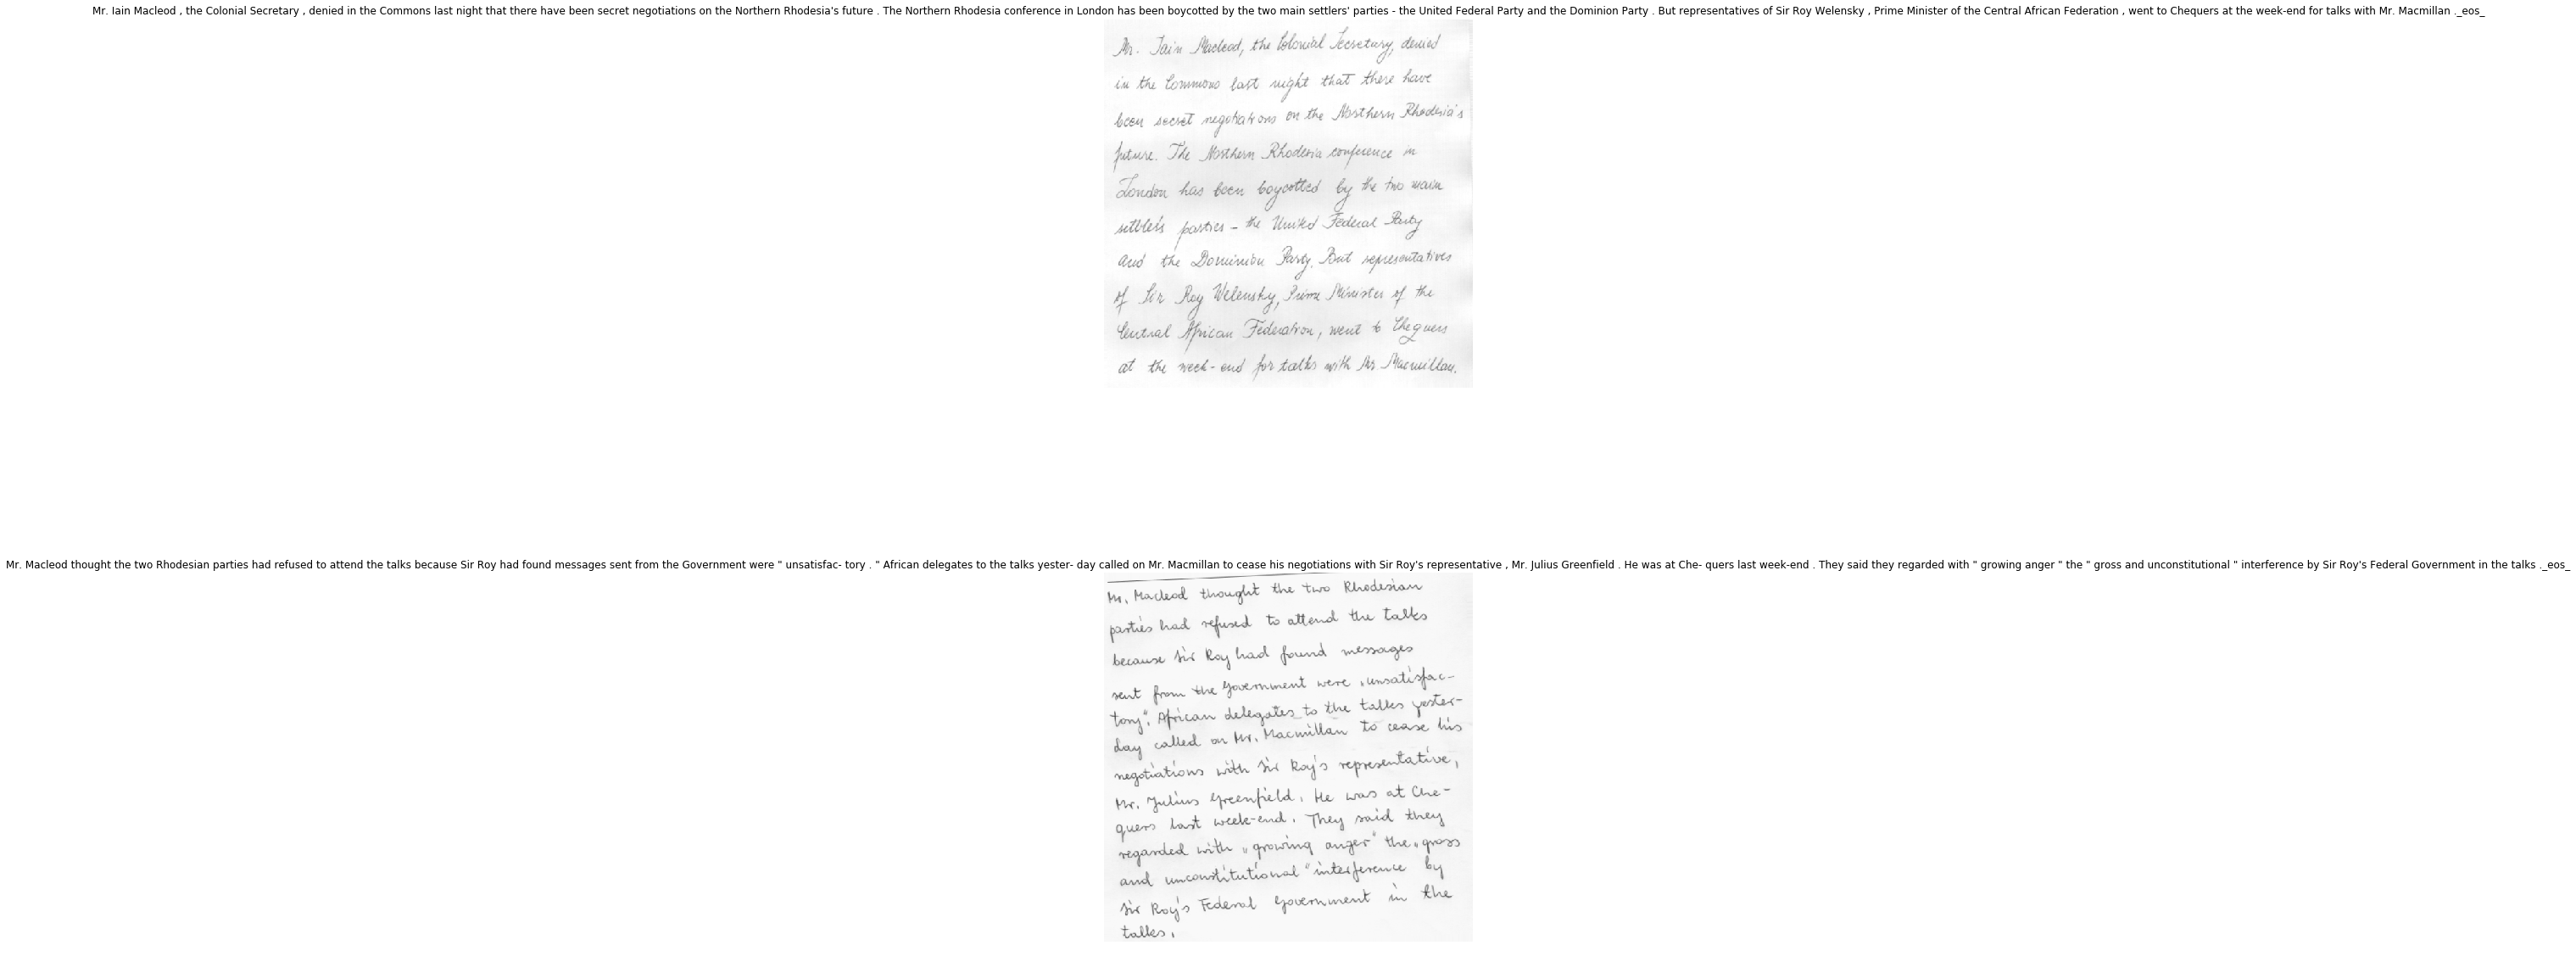

In [37]:
fig, axes = plt.subplots(2,1, gridspec_kw={'hspace': 0.5}, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])
    ax=show_img(x[i], ax=ax, title=t)

## Loss Fn

In [23]:
# categorical cross entropy loss
# list of probabilities for each word in vocab; target is correct word

def seq2seq_loss(input, target):
    target = target.permute(1,0).contiguous()
    tsl = target.size(0)
    sl,bs,nc = input.size()
    
    if sl>tsl: target = F.pad(target, (0,0,0,sl-tsl))
    if tsl>sl: target = target[:sl]  
#     if tsl>sl: input = F.pad(input, (0,0,0,0,0,tsl-sl))
        
    targ = target.view(-1)
    pred = input.view(-1, nc)

    # combination of LogSoftmax and NLLLoss
    return F.cross_entropy(pred, targ.long(), reduction='sum')/bs

In [24]:
import Levenshtein as Lev

# pulled from Sean Nareen's deepspeech decoder module
# https://github.com/SeanNaren/deepspeech.pytorch/blob/master/decoder.py

def cer(t, p):
    """
    Computes the Character Error Rate, defined as the edit distance.
    Arguments:
        t (string): target space-separated sentence
        p (string): prediction space-separated sentence
    """
    t, p, = t.replace(' ', ''), p.replace(' ', '')
    return Lev.distance(t, p)/len(t)

def wer(s1, s2):
    """
    Computes the Word Error Rate, defined as the edit distance between the
    two provided sentences after tokenizing to words.
    Arguments:
        s1 (string): space-separated sentence
        s2 (string): space-separated sentence
    """

    # build mapping of words to integers
    b = set(s1.split() + s2.split())
    word2char = dict(zip(b, range(len(b))))

    # map the words to a char array (Levenshtein packages only accepts
    # strings)
    w1 = [chr(word2char[w]) for w in s1.split()]
    w2 = [chr(word2char[w]) for w in s2.split()]

    return Lev.distance(''.join(w1), ''.join(w2))

In [25]:
def error_label(pred):
    ints = to_np(pred).astype(int)
    ints = ints[np.nonzero(ints)]
    return ' '.join([itos[i] for i in ints])

def char_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += cer(t,p)
    return error/bs

def word_error_rate(preds, targs):
    bs,sl = targs.size()      #=> ([bs, sl])
    # preds.size()            #=> ([sl, bs, vs])
        
    res = torch.argmax(preds, dim=2)
    error = 0
    for i in range(bs):
        p = error_label(res[:,i])
        t = error_label(targs[i])
        error += wer(t,p)
    return error/bs

# Arch

In [29]:
class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.4):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]    #(8,8,256)  sz: 128
        self.base = nn.Sequential(*modules)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp)
        features = features.flatten(2, 3).permute(2, 0, 1)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [30]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.1):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        # this is called once for each timestep
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = torch.tanh(w1e + w2h)                   # ([64, 30, 256])
        u = self.drop(u)
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [31]:
class Decoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers)
        if self.num_layers > 1: self.rnn.dropout = drop

    def forward(self, hidden, context):
        _, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return h[-1]

In [32]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.3):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [33]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1, drop=0.2):
        super(Net, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = Encoder(hidden_size)
        self.attention = Attention(hidden_size)
        self.decoder = Decoder(hidden_size, n_layers)
        
        self.embed   = nn.Embedding(vocab_size, hidden_size)
        self.drop    = nn.Dropout(drop)
        self.embed.weight.data.uniform_(-0.1, 0.1)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()  #bos token
        
        for i in range(self.seq_len):
            prev = self.drop(self.embed(dec_inp))
            
            context, a = self.attention(hidden, feats)
            hidden = self.decoder(hidden, context)
            out = self.output(prev, hidden, context)
            
            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            
        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [34]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(256, len(itos), seq_len, 1)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate]

# Arch mod

In [26]:
# modified for sz: 64

class Encoder(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()
        
        slices = {128: -4, 256: -3, 512: -2}
        s = slices[embed_size]
        
        net = f(True)
        modules = list(net.children())[:s]
        self.base = nn.Sequential(*modules)
        
#         self.linear0 = nn.Linear(embed_size, embed_size)
        
        #mlp
        self.drop = nn.Dropout(drop)
        self.linear1 = nn.Linear(embed_size, embed_size)
        self.linear2 = nn.Linear(embed_size, embed_size)
        
    def forward(self, inp):
        bs,nf,h,w = inp.size()
        
        features = self.base(inp).flatten(2, 3).permute(2, 0, 1)
#         features = self.linear0(features)
        
        # initial hidden is an average of features fed through an MLP
        h = self.drop(features)
        h = self.linear2(F.relu(self.linear1(h))).mean(0)
                        
        return features, h

In [27]:
def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

class Attention(nn.Module):
    def __init__(self, embed_size, drop=0.5):
        super().__init__()

        self.attn_1 = nn.Linear(embed_size, embed_size)
        self.attn_2 = nn.Linear(embed_size, embed_size)
        self.drop   = nn.Dropout(drop)
        self.attn_v = rand_p(embed_size)
        
    def forward(self, hidden, feats):
        w1e = self.attn_1(feats)                    # ([64, 30, 256])
        w2h = self.attn_2(hidden)                   # ([30, 256])
        u = self.drop(torch.tanh(w1e + w2h))        # ([64, 30, 256])
        a = torch.softmax(u @ self.attn_v, 0)       # ([64, 30]) - attention mask
        context = (a.unsqueeze(2) * feats).sum(0)   # ([30, 256]) - weighted sum of features w/ attention
        
        return context, a

In [28]:
class RNNDecoder(nn.Module):
    def __init__(self, embed_size, num_layers, drop=0.5):
        super().__init__()
        
        self.num_layers = num_layers
        self.rnn = nn.GRU(embed_size, embed_size, num_layers, dropout=drop)

    def forward(self, context, hidden):
        out, h = self.rnn(context.unsqueeze(0), hidden.expand(self.num_layers, -1, -1).contiguous())
        
        return out[-1]

In [29]:
class DeepOutputLayer(nn.Module):
    def __init__(self, embed_size, vocab_size, drop=0.5):
        super().__init__()
        
        self.w0 = nn.Linear(embed_size, embed_size)
        self.w1 = nn.Linear(embed_size, embed_size)
        self.w2 = nn.Linear(embed_size, embed_size)
        self.w3 = nn.Linear(embed_size*3, vocab_size)
        self.drop = nn.Dropout(drop)
        
    def forward(self, prev, hidden, context):
        # this is called once for each timestep
        #(30,256)
        a = self.w0(prev)
        b = self.w1(hidden)
        c = self.w2(context)
        out = torch.cat([a,b,c], 1)
        
        return self.w3(self.drop(out))

In [30]:
class Net(nn.Module):
    def __init__(self, hidden_size, vocab_size, seq_len, n_layers=1):
        super(Net, self).__init__()
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.encoder = Encoder(hidden_size)
        self.attn    = Attention(hidden_size)
        self.decoder = RNNDecoder(hidden_size, n_layers)
        self.embed   = nn.Embedding(vocab_size, hidden_size)

        self.output  = DeepOutputLayer(hidden_size, vocab_size)
        
    def forward(self, x, ret_attn=False):
        bs = x.size(0)
        feats, hidden = self.encoder(x)
        
        res,attns = [],[]
        dec_inp = torch.ones(bs, device=device).long()
        
        for i in range(self.seq_len):
            prev = self.embed(dec_inp)
            
            context, a = self.attn(hidden, feats)
            hidden = self.decoder(context, hidden)
            out = self.output(prev, hidden, context)
            
            if (self.seq_len-i)%50==0: hidden = repackage_var(hidden)

            res.append(out)
            attns.append(a)
            dec_inp = out.data.max(1)[1]
            if (dec_inp==0).all(): break

        res = torch.stack(res)
        if ret_attn: res = res,torch.stack(attns)
        return res

In [31]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
rnn = Net(128, len(itos), 50, 3)
learn = RNN_Learner(data, SingleModel(to_gpu(rnn)), opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [char_error_rate]

In [38]:
learn.set_data(data)

In [39]:
lr=1e-3
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   char_error_rate           
    0      152.263715 151.456849 0.991347  
    1      151.976927 151.540686 0.991347                  
    2      151.889047 151.405112 0.991347                  



[151.40511194864908, 0.9913466580106083]

# Baseline - resnet/custom_head

In [35]:
class Head(nn.Module):
    def __init__(self, em_sz, seq_len, vocab_size, drop=0.3):
        super().__init__()
        
        self.pool = nn.AdaptiveMaxPool1d(seq_len)
        self.fc1  = nn.Linear(em_sz, em_sz*4)
        self.fc2  = nn.Linear(em_sz*4, vocab_size)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.pool(x.flatten(2,3)).permute(0,2,1)
        x = self.fc2(self.drop(F.relu(self.fc1(x))))
        return x.permute(1,0,2).contiguous()

In [37]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))
head = Head(256, seq_len, len(itos))
net = ConvnetBuilder(f, 0, 0, True, custom_head=head, xtra_cut=1).model
learn = ConvLearner.from_model_data(to_gpu(net), data, opt_fn=opt_fn)
learn.clip = 0.25
learn.crit = seq2seq_loss
learn.metrics = [word_error_rate] #[char_error_rate]

# Train

 92%|█████████▏| 61/66 [01:28<00:07,  1.44s/it, loss=1.9e+03] 

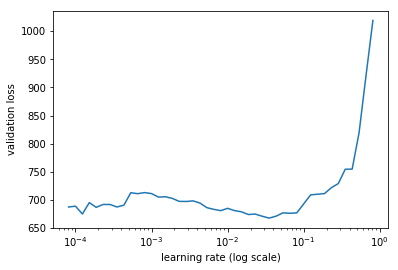

In [46]:
learn.lr_find()
learn.sched.plot()

In [33]:
lr=1e-3
learn.fit(lr, 1, cycle_len=1)

# em_sz: 256
# 149.260142 0.978963    seq_len: 50, sz: 500, bs: 10
# 150.115528 0.981975    seq_len: 50, sz: 224, bs: 30

# em_sz: 512, sz: 500, bs: 10


epoch      trn_loss   val_loss   char_error_rate         
    0      161.285217 150.115528 0.981975  



[150.11552810668945, 0.9819754754156605]

In [40]:
lr=1e-2
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))
# use_clr_beta: (ratio btw initial chosen lr, % of cycle on slow decrease, *momentum values)

# words - 256
# 662.064957 661.173696 73.030303

epoch      trn_loss   val_loss   word_error_rate             
    0      703.041919 672.550175 72.662338 
    1      683.886809 664.671728 73.199134               
    2      673.155137 664.931966 73.155844               
    3      673.408354 663.795872 72.683983               
    4      662.064957 661.173696 73.030303               


[661.1736957500507, 73.03030303030303]

## Increase Size

In [42]:
sz = 512
bs = 20

In [45]:
learn.set_data(data)

In [47]:
lr=1e-2
learn.fit(lr, 5, cycle_len=1, use_clr_beta=(10,10,0.95,0.85))

# 625.986565 646.537818 72.835498

epoch      trn_loss   val_loss   word_error_rate           
    0      653.095792 640.735108 73.112554 
    1      641.559992 641.204503 72.744589                 
    2      638.013465 643.302949 72.675325                 
    3      636.125094 644.748158 72.675325                 
    4      625.986565 646.537818 72.835498                 


[646.5378177527225, 72.83549783549783]

# Results

In [40]:
x,y = next(iter(data.val_dl))
learn.model.eval()
preds,attns = learn.model(x, ret_attn=True)   #attns ([sl, 64, bs])
# preds = learn.model(x)
probs = F.softmax(preds, -1)
res = torch.argmax(probs, dim=-1)

In [41]:
seq2seq_loss(preds, y), char_error_rate(preds, y)

(tensor(153.4018, device='cuda:0', grad_fn=<DivBackward0>), 0.9920402592651746)

In [44]:
imgs = data.trn_ds.denorm(x)

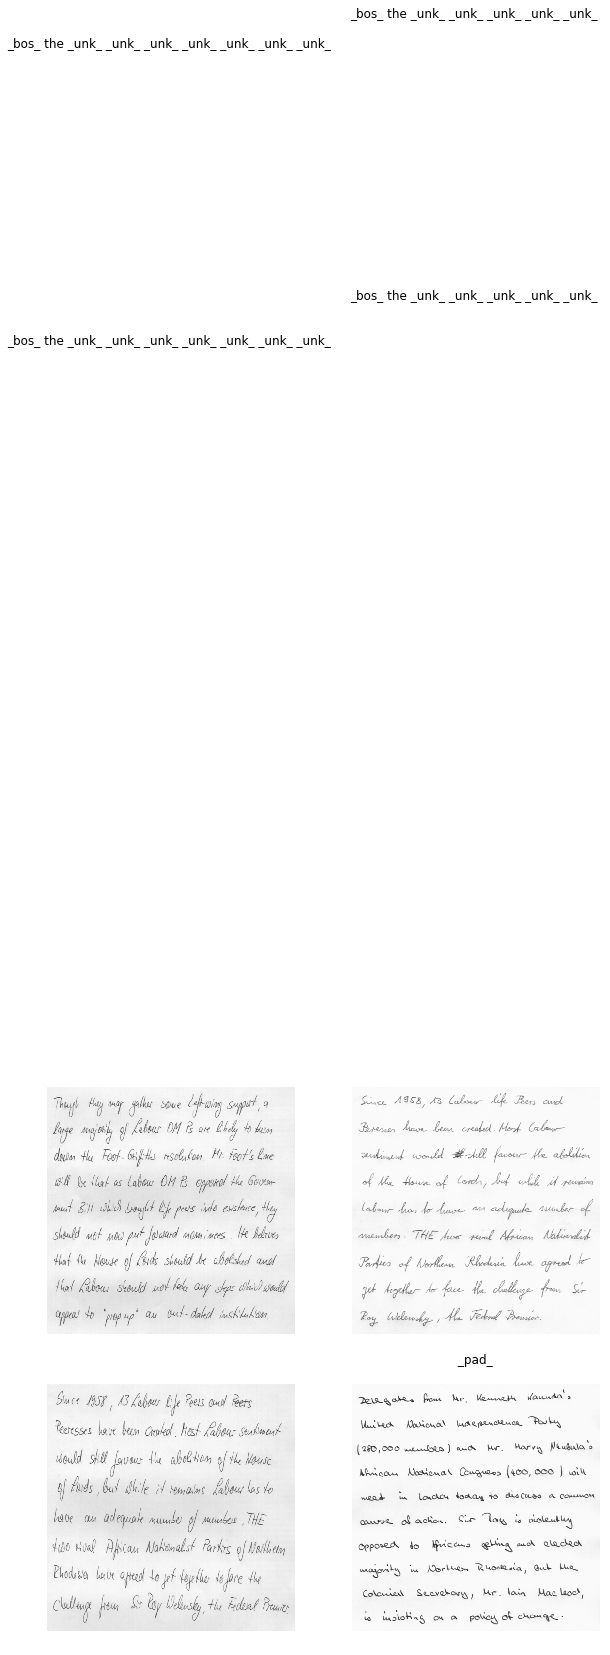

In [50]:
fig, axes = plt.subplots(4,4, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
    t = label_text(y[i])     #=>  char indices
    p = label_text(res[:,i])
    ax=show_img(imgs[i], ax=ax, title=p)#t+' '+p)
    
plt.tight_layout(pad=0.1)

## Attention

In [55]:
def scale_attn_to_img(att, sz):
    p = 16
    num = sz // p
    a = att.reshape(p,p)
    return np.repeat(np.repeat(a,num, axis=0), num, axis=1)

In [59]:
def scale_attn_to_img(att, sz):
    p = 8
    num = sz // p
    a = att.reshape(num,num)
    return np.repeat(np.repeat(a,p, axis=0), p, axis=1)

In [60]:
idx  = 0
img  = imgs[idx]
pred = res[:,idx]
attn = to_np(attns[:,:,idx])  # first batch

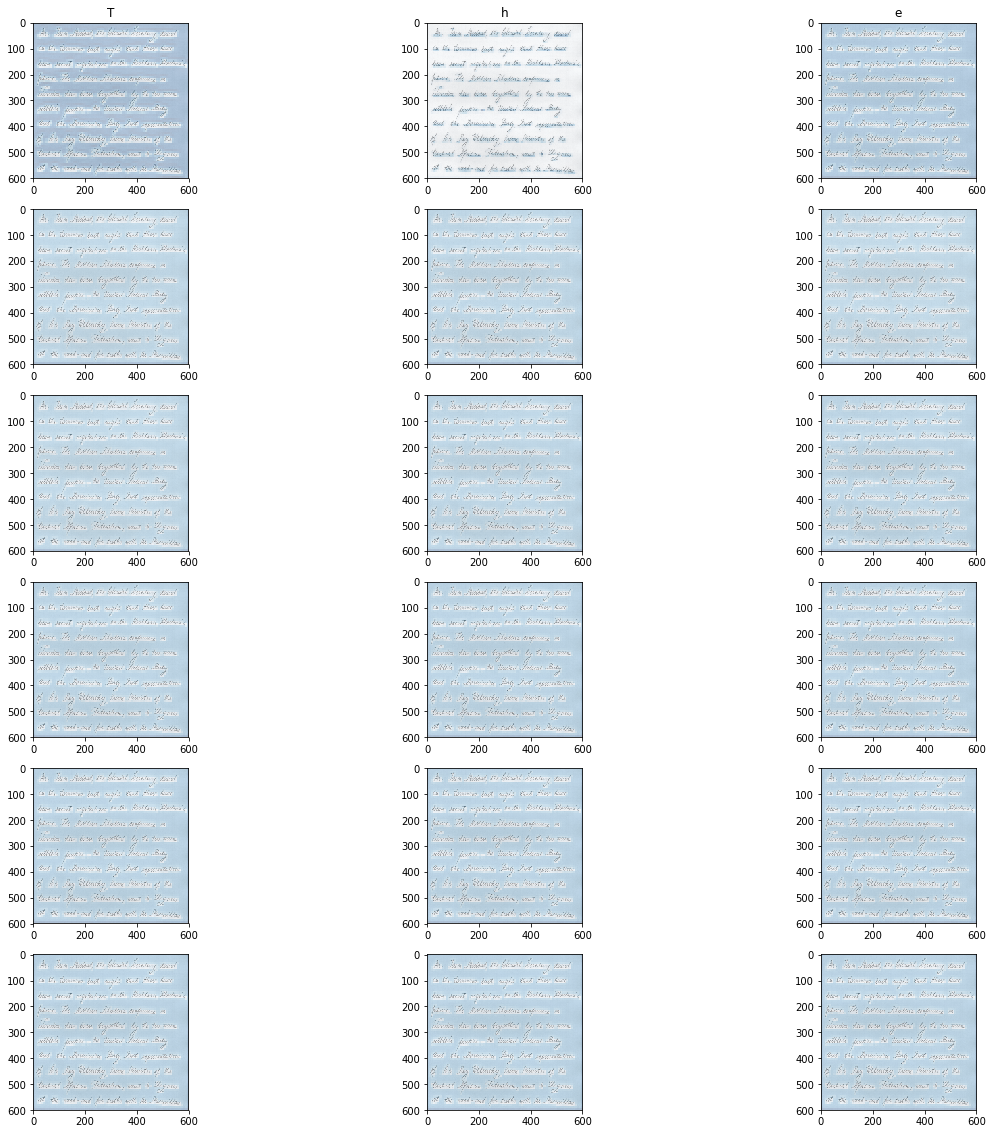

In [61]:
fig, axes = plt.subplots(6, 3, figsize=(20, 20))
for i,ax in enumerate(axes.flat):
#     ax.plot(attn[i])
    a = scale_attn_to_img(attn[i], 600)
    ax.imshow(img, alpha=None)
    ax.imshow(a, cmap='Blues', interpolation='nearest', alpha=0.3)
    ax.set_title(itos[pred[i].item()])